In [1]:
%%capture
# Setup: Install packages we will need in this notebook
%pip install pyfmrheo
%pip install matplotlib

In [2]:
from pyfmreader import loadfile
from pyfmrheo.routines.MicrorheologyFFT import doMicrorheologyFFT
import matplotlib.pyplot as plt

In [3]:
# Define global parameters for plotting
plt.rcParams["figure.figsize"] = (10,5)

In [4]:
# Define path of file to process
file_path = r"../tests/testfiles/map-data-2022.10.29-12.46.13.749.jpk-force-map"

In [5]:
# Load File
file = loadfile(file_path)
filemetadata = file.filemetadata
print(filemetadata['file_type'])

jpk-force-map


In [6]:
# Get some of the file metadata
closed_loop = filemetadata['z_closed_loop']
file_deflection_sensitivity = filemetadata['defl_sens_nmbyV'] #nm/V
file_spring_constant = filemetadata['spring_const_Nbym'] #N/m
height_channel = filemetadata['height_channel_key']

deflection_sensitivity = file_deflection_sensitivity / 1e9 #m/V
spring_constant = file_spring_constant

print(f"Closed loop: {closed_loop}")
print(f"Height channel: {height_channel}")
print(f"Deflection Sens.: {deflection_sensitivity} m/V")
print(f"Spring Constant: {spring_constant} N/m")

Closed loop: false
Height channel: measuredHeight
Deflection Sens.: 1.4678505383171551e-08 m/V
Spring Constant: 0.191 N/m


In [7]:
# Define parameters to perform the Microrheology analysis
maxnoncontact = 1e-6 #um
pts_downsample = 100

param_dict = {
    'height_channel': height_channel,   # Channel where to find the height data
    'def_sens': deflection_sensitivity, # Deflection sensitivity in m/V
    'k': spring_constant,               # Spring constant in N/m
    'contact_model': 'paraboloid',      # Geometry of the indenter: paraboloidal, conical, pyramidal
    'tip_param': 5e-06,                 # Tip raidus in meters or tip angle in degrees
    'curve_seg': 'extend',              # Segement to perform the fit: extend or retract
    'correct_tilt': False,              # Perform tilt correction
    'tilt_min_offset': 1e-08,           # Maximum range where to perform the tilt correction in meters
    'tilt_max_offset': 1e-06,           # Minimum range where to perform the tilt correction in meters
    'poisson': 0.5,                     # Poisson's ratio
    'poc_method': 'RoV',                # Method to find the contact point: RoV or RegulaFalsi
    'poc_win': 4e-07,                   # Window size for the RoV method
    'max_ind': 0.0,                     # Maximum indentation range for fit in meters
    'min_ind': 0.0,                     # Minimum indentation range for fit in meters
    'max_force': 0.0,                   # Maximum force range for fit in Newtons
    'min_force': 0.0,                   # Minimum force range for fit in Newtons
    'fit_range_type': 'full',           # Fit data range: full, indentation or force
    'd0': 0.0,                          # Initial point of contact
    'slope': 0.0,                       # Initial slope
    'auto_init_E0': True,               # Estimate automatically the initial value of the Young's Modulus
    'E0': 1000,                         # Initial Young's Modulus value
    'f0': 0.0,                          # Initial F0 value
    'contact_offset': maxnoncontact,    # Baseline offset for the Hertz Fit
    'fit_line': False,                  # Fit line to the baseline
    'downsample_flag': True,            # Downsample the signal for Hertz Fit
    'pts_downsample': pts_downsample,   # Number of points to downsample
    'offset_type':'percentage',         # How to correct for baseline offset: percentage or value
    'max_offset':.3,                    # Max percentage to compute offset
    'min_offset':0,                     # Min percentage to compute offset
    'max_freq': 500,                    # Maximum frequency to process in Hz
    'piezo_char_data': None,            # Piezo Characterization data for correction
    'bcoef': 0
}

In [8]:
# Select curve by index
curve_idx = 0
force_curve = file.getcurve(curve_idx)
# Preprocess curve
force_curve.preprocess_force_curve(param_dict['def_sens'], param_dict['height_channel'])

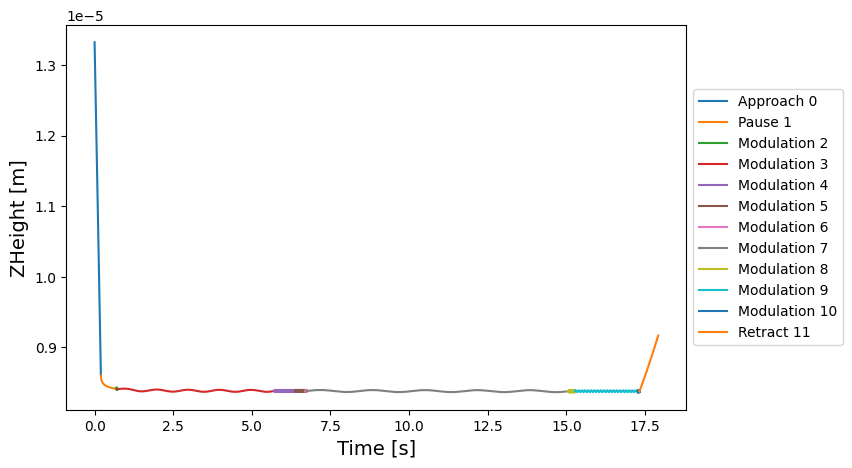

In [9]:
# Plot the force curve modulation segments
time_0 = 0
fig = plt.figure()
ax = plt.subplot(111)
for segid, segment in force_curve.get_segments():
    time = segment.time
    zheight = segment.zheight
    ax.plot(time + time_0, zheight, label=f"{segment.segment_type} {segid}")
    time_0 = time_0 + time[-1]
ax.set_xlabel("Time [s]", fontsize = 14)
ax.set_ylabel("ZHeight [m]", fontsize=14)

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [10]:
# JPK files require the height signal to be shifted
if filemetadata['file_type'] in ('jpk-force', 'jpk-force-map', 'jpk-qi-data'):
    force_curve.shift_height()

In [11]:
# Perform Microrheology Analysis
frequencies_results, G_storage_results, G_loss_results, gamma2_results, fi_results,  amp_quotient_results, bcoef, wc = doMicrorheologyFFT(force_curve, param_dict)

The frequency found at index 0.9966777408637872 does not match with the frequency applied 1.0
The frequency found at index 59.98421468034728 does not match with the frequency applied 60.0
The frequency found at index 119.96842936069456 does not match with the frequency applied 120.0
The frequency found at index 0.5980066445182725 does not match with the frequency applied 0.6
The frequency found at index 199.89479221462386 does not match with the frequency applied 200.0
The frequency found at index 9.994447529150474 does not match with the frequency applied 10.0


C:\Users\javier.lopez\AppData\Local\Programs\Python\Python39\lib\site-packages\pyfmrheo\models\hertz.py:161: RuntimeWarning: divide by zero encountered in divide
  a = (self.get_residuals(indentation, force, sample_height)**2/force)
C:\Users\javier.lopez\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\signal\_spectral_py.py:1867: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


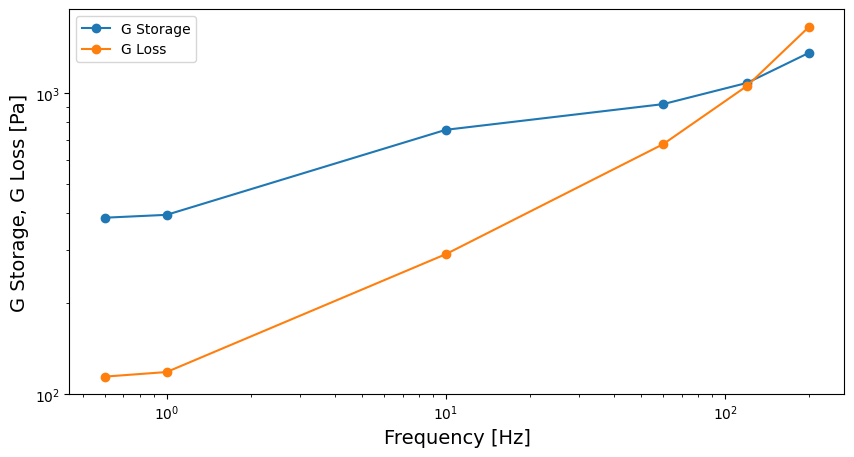

In [12]:
# Plot Microrheology results
plt.plot(frequencies_results, G_storage_results, '-o', label='G Storage')
plt.plot(frequencies_results, G_loss_results, '-o', label='G Loss')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Frequency [Hz]", fontsize=14)
plt.ylabel("G Storage, G Loss [Pa]", fontsize=14)
plt.legend()
plt.show()